# Blight Prediction

## Get the Data
We begin with downloading the data from [Detroit Open Data Portal](https://data.detroitmi.gov/). There are five data files used in this analysis:
* `Detroit_Demolitions.csv` : each record represents a demolition executed up to date
* `Upcoming_Detroit_Demolitions.csv` : each record represents an upcoming demolition
* `Blight_Violations.csv` : each record represents a blight violation incident
* `DPD__All_Crime_Incidents__2009_-_Present__Provisional_.csv` : each record shows a criminal incident in Detroit since 2009
* `Improve_Detroit__Submitted_Issues.csv` : each record represents a issue submitted for consideration through the Improve Detroit website or application (just like a 311 complaining call)

In [26]:
!curl -o Detroit_Demolitions.csv https://data.detroitmi.gov/api/views/rv44-e9di/rows.csv?accessType=DOWNLOAD 
!curl -o Upcoming_Detroit_Demolitions.csv https://data.detroitmi.gov/api/views/tsqq-qtet/rows.csv?accessType=DOWNLOAD
!curl -o Blight_Violations.csv https://data.detroitmi.gov/api/views/teu6-anhh/rows.csv?accessType=DOWNLOAD
!curl -o DPD__All_Crime_Incidents__2009_-_Present__Provisional_.csv https://data.detroitmi.gov/api/views/b4hw-v6w2/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1301k  100 1301k    0     0  1679k      0 --:--:-- --:--:-- --:--:-- 1679k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22856  100 22856    0     0  74255      0 --:--:-- --:--:-- --:--:-- 74207
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  157M  100  157M    0     0  6707k      0  0:00:24  0:00:24 --:--:-- 7093k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  249M    0  249M    0     0   984k      0 --:--:--  0:04:19 --:--:-- 1492k


In [12]:
#we can also use urllib to download the file
import urllib
url = 'https://data.detroitmi.gov/api/views/fwz3-w3yn/rows.csv?accessType=DOWNLOAD'
urllib.urlretrieve(url, 'Improve_Detroit__Submitted_Issues.csv') 

('Improve_Detroit__Submitted_Issues.csv',
 <httplib.HTTPMessage instance at 0x103d92dd0>)

## List of Buildings

The first step is to extract a list of buildings from the longitude and lattitude data. To view the location data, I use Google fusion table to create a [map](https://fusiontables.google.com/embedviz?q=select+col7+from+1dZhBHGvqIljSkDyBD5-6Dl6sTVg-qO6jLtIOHcCz&viz=MAP&h=false&lat=42.37727998411888&lng=-83.10039014405822&t=1&z=12&l=col7&y=2&tmplt=2&hml=TWO_COL_LAT_LNG) for the data file `Detroit_Demolitions.csv`. We can see the demolitions are distributed across the entire region of Detroit. Similar map can be created with other data file, which may show a different density of records.

Here we use a simple model to build the list of buildings. We divide the entire landscape into small squares with side of 10 meters long and label each squares as a building. First of all, we need to find the range of the Latitude and Longitude data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [64]:
#We will read all the data files and find their latitude and longitude range.

demolitions = pd.read_csv('Detroit_Demolitions.csv')
Lat_max = max(demolitions['Latitude'])
Lat_min = min(demolitions['Latitude'])
Lon_max = max(demolitions['Longitude'])
Lon_min = min(demolitions['Longitude'])

In [65]:
future_demolitions = pd.read_csv('Upcoming_Detroit_Demolitions.csv')
A=future_demolitions.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])

In [66]:
violations = pd.read_csv('Blight_Violations.csv',low_memory=False)
A=violations.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [67]:
crimes = pd.read_csv('DPD__All_Crime_Incidents__2009_-_Present__Provisional_.csv',low_memory=False)

#remove the records with non-meaningful Latidude and Longitude data (restrict the region to Detroit city)
crimes = crimes[(crimes.LON < Lon_max+0.01) & (crimes.LON > Lon_min-0.01) & (crimes.LAT < Lat_max+0.01) & (crimes.LAT > Lat_min-0.01)]
crimes = crimes.rename(index=str,columns={"LON": "Longitude", "LAT": "Latitude"})
A=crimes.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])
print(Lat_max,Lat_min,Lon_max,Lon_min)

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


42.4599 42.2459 -82.9013 -83.2973


In [68]:
issues = pd.read_csv('Improve_Detroit__Submitted_Issues.csv',low_memory=False)

#remove the records with non-meaningful Latidude and Longitude data (restrict the region to Detroit city)
issues = issues[(issues.lng < Lon_max+0.01) & (issues.lng > Lon_min-0.01) & \
                (issues.lat < Lat_max+0.01) & (issues.lat > Lat_min-0.01)]
issues = issues.rename(index=str,columns={"lng": "Longitude", "lat": "Latitude"})
A=issues.describe()
Lat_min = min(Lat_min,A['Latitude']['min'])
Lat_max = max(Lat_max,A['Latitude']['max'])
Lon_min = min(Lon_min,A['Longitude']['min'])
Lon_max = max(Lon_max,A['Longitude']['max'])

//anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [69]:
#combine all the locations data into one dataframe
locations = demolitions[['Latitude','Longitude']].append(future_demolitions[['Latitude','Longitude']]).append(violations[['Latitude','Longitude']])
locations = locations.append(crimes[['Latitude','Longitude']]).append(issues[['Latitude','Longitude']])
locations = locations.dropna(how='any')

des=locations.describe()
Lat_min = des['Latitude']['min']
Lat_max = des['Latitude']['max']
Lon_min = des['Longitude']['min']
Lon_max = des['Longitude']['max']
print(Lat_max,Lat_min,Lon_max,Lon_min)

42.4599 42.2459 -82.9013 -83.2973


To compute the distance between two geographic coordinates, I refer to [this site](http://www.movable-type.co.uk/scripts/latlong.html). For small distances, I use the equirectangular approximation:
![Formula](./image.png)
where φ/λ are latitude/longitude in radians, φ<sub>m</sub>  = (φ<sub>1</sub>  + φ<sub>2</sub> )/2, and R = 6,371 km is the radius of earth.
Actually, since we are only interested in the small Detroit area, we will further simplify the expression by taking φ<sub>m</sub>  = (φ<sub>max</sub>  + φ<sub>min</sub>)/2 which is indepedent of the specific coordinates. In this way, we can directly map the longitude and latitude coordinates into planar x, y coordinates:
x = λRcos(φ<sub>m</sub>),
y = φR.

This approximation is justified by the fact that the percent difference between the cosine of the largest latitude and the smallest latitude is less than 1%, see the following:

In [70]:
import math
radi = math.pi/180;

diff=(math.cos(Lat_min*radi)-math.cos(Lat_max*radi))/math.cos((Lat_max+Lat_min)/2*radi)
print('The percent difference is %.2f%%.'%(diff*100));

The percent difference is 0.34%.


In [71]:
R = 6371000
phim = (Lat_min+Lat_max)*radi/2
#let the left lower point to be the origin (0,0)
locations['x'] = (locations['Longitude']-Lon_min)*R*radi*math.cos(phim)
locations['y'] = (locations['Latitude']-Lat_min)*R*radi

In [72]:
#arrange the Building ID as following:
#...
#3255 3256 3257 ...
#0 1 2 3 4 5 ... 3254
xtotal=int(max(locations['x'])/10)+1
print(xtotal)

locations['Building_ID'] = ((locations['x']/10).astype(int)+(locations['y']/10).astype(int)*xtotal).astype(int)
locations.head()

3255


Latitude  Longitude             x             y  Building_ID
0  42.306876 -83.116669  14843.189166   6780.221847      2208374
1  42.396117 -83.191366   8705.030704  16703.368296      5436720
2  42.397525 -83.195185   8391.207831  16859.930752      5485514
3  42.397671 -83.191433   8699.525040  16876.165212      5492054
4  42.404791 -83.183196   9376.393070  17667.873089      5749267

In [73]:
#to query the buiding id from the latitude and longitude
locations[locations.Latitude == 42.245900]['Building_ID']

602159    1222
Name: Building_ID, dtype: int64

In [74]:
#drop duplicates in locations so that the number below shows how many different (latitude,longitude)...
# sets are labeled as the same building_ID
locations = locations.drop_duplicates()
lc_count=locations.groupby('Building_ID').count()
lc_count.sort_values(by='x').tail(10)

Latitude  Longitude   x   y
Building_ID                             
3009480             7          7   7   7
4246381             7          7   7   7
4454651             8          8   8   8
4794168             8          8   8   8
5116339             8          8   8   8
3087283             9          9   9   9
6967258            11         11  11  11
3356518            11         11  11  11
3969840            12         12  12  12
3356517            15         15  15  15

## Construct Training Set
Next, we will construct a training set by labeling the blighted/not-blighted buildings. We label the buildings in the Upcoming_Detroit_Demolitions.csv file to be blighted and all the other as not blighted.

In [75]:
future_demolitions2 = pd.merge(future_demolitions, locations, on=['Latitude', 'Longitude'])
count_blighted=len(future_demolitions2.index)
print("The number of blighted buildings is",count_blighted)
future_demolitions2['IsBlighted'] = pd.Series(1,index=list(range(count_blighted)),dtype='int')

The number of blighted buildings is 175


In [76]:
blighted = future_demolitions2[['Building_ID', 'IsBlighted']]
blighted = blighted.drop_duplicates()
count_blighted=len(blighted.index)
print("The number of blighted buildings after dropping duplicates is",count_blighted)

The number of blighted buildings after dropping duplicates is 175


In [77]:
locations2 = pd.merge(locations, blighted, how='outer', on='Building_ID',sort=False)
locations2 = locations2.fillna(0)

not_blighted = locations2[['Building_ID', 'IsBlighted']]
not_blighted = not_blighted[not_blighted.IsBlighted == 0]
not_blighted = not_blighted.drop_duplicates()
count_notblighted = len(not_blighted.index)
print("The number of not-blighted buildings after dropping duplicates is", count_notblighted)

The number of not-blighted buildings after dropping duplicates is 767806


Now we have two tables **blighted** and **not_blighted** which list the Building_ID and IsBlighted label for blighted building and not-blighted building respectively.

In [78]:
violations2 = pd.merge(violations, locations2, on=['Latitude', 'Longitude'])
vio_count = violations2[['Building_ID','x']]
vio_count = vio_count.groupby('Building_ID').count()
vio_count = vio_count.rename(index=str,columns={"x": "Violation_Count"})

vio_count2 = vio_count
vio_count2['Building_ID'] = vio_count.index.astype('int')
vio_count2.index = pd.Series(range(len(vio_count.index)))

In [79]:
blighted2 = pd.merge(blighted, vio_count2, how='left', on=['Building_ID'])
blighted2 = blighted2.fillna(0)

not_blighted2 = pd.merge(not_blighted, vio_count2, how='left', on='Building_ID')
not_blighted2 = not_blighted2.fillna(0)

In [80]:
crimes2 = pd.merge(crimes, locations2, on=['Latitude', 'Longitude'])
crime_count = crimes2[['Building_ID','x']]
crime_count = crime_count.groupby('Building_ID').count()
crime_count = crime_count.rename(index=str,columns={"x": "Crime_Count"})

crime_count['Building_ID'] = crime_count.index.astype(int)
crime_count.index = pd.Series(range(len(crime_count.index)))

In [81]:
not_blighted2 = pd.merge(not_blighted2, crime_count, how='left', on='Building_ID')
not_blighted2 = not_blighted2.fillna(0)

blighted2 = pd.merge(blighted2, crime_count, how='left', on='Building_ID')
blighted2 = blighted2.fillna(0)

In [82]:
issues2 = pd.merge(issues, locations2, on=['Latitude', 'Longitude'])
issues_count = issues2[['Building_ID','x']]
issues_count = issues_count.groupby('Building_ID').count()
issues_count = issues_count.rename(index=str,columns={"x": "Issue_Count"})

issues_count['Building_ID'] = issues_count.index.astype(int)
issues_count.index = pd.Series(range(len(issues_count.index)))

not_blighted2 = pd.merge(not_blighted2, issues_count, how='left', on='Building_ID')
not_blighted2 = not_blighted2.fillna(0)
blighted2 = pd.merge(blighted2, issues_count, how='left', on='Building_ID')
blighted2 = blighted2.fillna(0)

Now we have two tables **blighted2** and **not_blighted2** which list the "Building_ID" for blighted (IsBlighted = 1) and not-blighted (IsBlighted = 0) buildings respectively, together with three features "Violation_Count", "Crime_Count" and "Issue_Count" indicating the number of blight violation incidents, the number of crimes incidents and the number of issues associated with that building. Let's first inspect these two data frames.

In [83]:
print("the number of blighted building is",count_blighted,"and the number of not-blighted building is",count_notblighted)

the number of blighted building is 175 and the number of not-blighted building is 767806


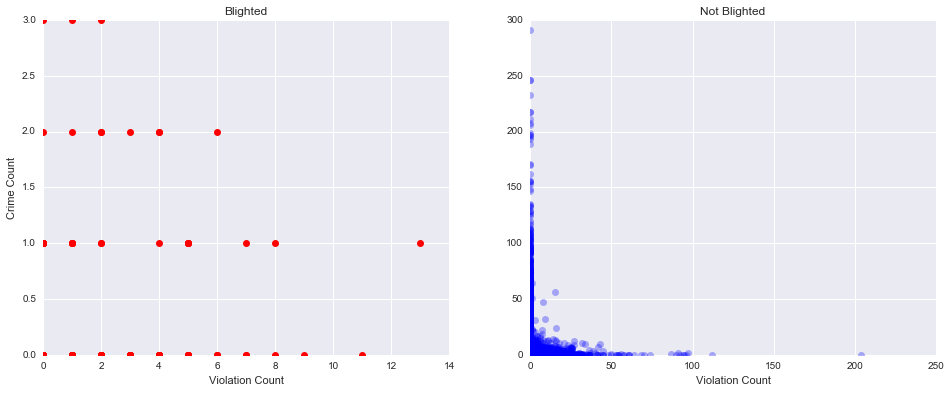

In [84]:
fig, ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
plt.plot(blighted2['Violation_Count'],blighted2['Crime_Count'],'ro')
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Crime Count")

plt.subplot(122)
plt.plot(not_blighted2['Violation_Count'],not_blighted2['Crime_Count'],'bo',alpha=0.3)
plt.xlabel("Violation Count")
plt.title('Not Blighted')

#fig.savefig('test.eps', format='eps')

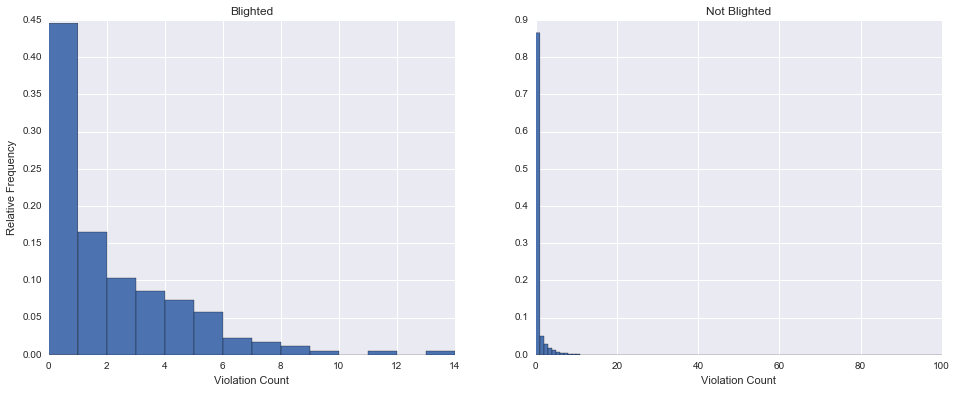

In [85]:
import numpy
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted2['Violation_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted2['Violation_Count'],bins, normed=1)
plt.title('Not Blighted')
plt.xlabel("Violation Count")
plt.axis([0, 100, 0.0, 0.9])
fig.savefig('test.eps', format='eps')

From the above figures we can see that of all the not-blighted buildings, there are about 84% of them have zero violation count. For blighted buildings, the relative frequency of the zero violation count buildings is much lower (0.45).

[0, 100, 0.0, 10000]

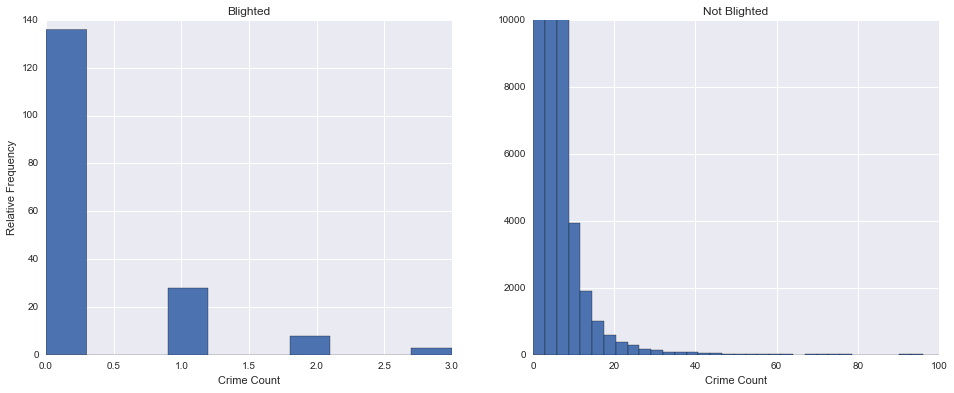

In [86]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted2['Crime_Count'])
plt.title('Blighted')
plt.xlabel("Crime Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted2['Crime_Count'],100)
plt.title('Not Blighted')
plt.xlabel("Crime Count")
plt.axis([0, 100, 0.0, 10000])
#fig.savefig('test.eps', format='eps')

[0, 100, 0.0, 1000]

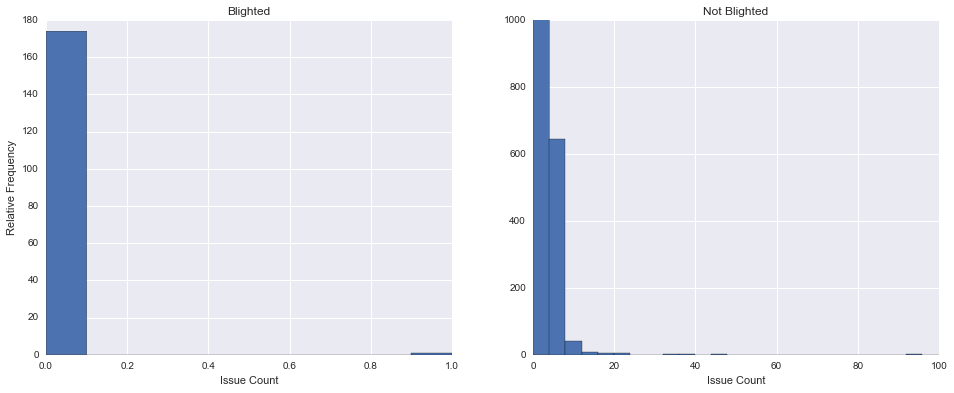

In [87]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted2['Issue_Count'])
plt.title('Blighted')
plt.xlabel("Issue Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted2['Issue_Count'],100)
plt.title('Not Blighted')
plt.xlabel("Issue Count")
plt.axis([0, 100, 0.0, 1000])
#fig.savefig('test.eps', format='eps')

From the histograms of the crime-count and issue-count, we can see that our sample for blighted buildings may not be large enough. This sample generally has little crimes or issues. Note that in the not-blighted figures, the actual number at small x-axis region exceeds the y-axis limit. This limit is just set for clear view. The main feature is that the majority of the not-blighted bulidings have zero or nearly zero crime or issue count, but the histogram has a long tail.

In [88]:
demolitions2 = pd.merge(demolitions, locations, on=['Latitude', 'Longitude'])
demolitions2['IsBlighted'] = pd.Series(1,index=list(range(len(demolitions2.index))),dtype='int')

new_blighted = demolitions2[['Building_ID','IsBlighted']]
new_blighted = new_blighted.rename(index=str,columns={"IsBlighted": "IsNewBlighted"})
new_blighted = new_blighted.drop_duplicates()
print(len(new_blighted.index))

10465


In [89]:
not_blighted3 = pd.merge(not_blighted2, new_blighted, how='outer', on='Building_ID')
not_blighted3['IsNewBlighted'] = not_blighted3['IsNewBlighted'].fillna(0)
not_blighted3 = not_blighted3.dropna(how='any')

In [90]:
blighted3 = blighted2
blighted3['IsNewBlighted'] = pd.Series(1, index=list(range(len(blighted3.index))), dtype='int')

temp = not_blighted3[not_blighted3.IsNewBlighted == 1]
blighted3 = blighted3.append(temp, ignore_index=True) #note that append may produce duplicate index

In [91]:
temp = not_blighted3[not_blighted3.IsNewBlighted == 0]
temp.index =list(range(len(temp.index)))
not_blighted3 = temp

Now we have two data frames **blighted3** and **not_blighted3** which represents the blighted buildings and not-blighted building. Note we label the buildings in both demolitions and future_demolitions as blighted. The current **blighted3** data frame contains much more records than the **blighted2** table.

In [92]:
count_blighted = len(blighted3)
count_notblighted = len(not_blighted3)
print("the number of blighted building is",count_blighted,"and the number of not-blighted building is",count_notblighted)

the number of blighted building is 10635 and the number of not-blighted building is 757346


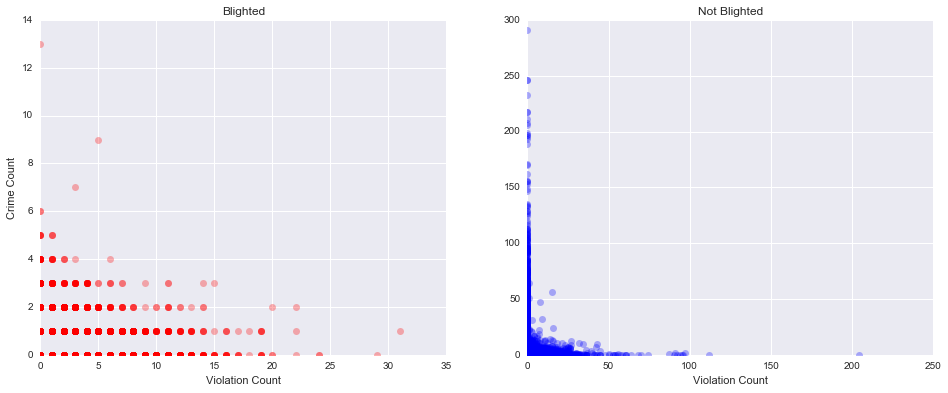

In [93]:
fig, ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
plt.plot(blighted3['Violation_Count'],blighted3['Crime_Count'],'ro',alpha = 0.3)
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Crime Count")

plt.subplot(122)
plt.plot(not_blighted3['Violation_Count'],not_blighted3['Crime_Count'],'bo',alpha=0.3)
plt.xlabel("Violation Count")
plt.title('Not Blighted')

[0, 30, 0.0, 0.9]

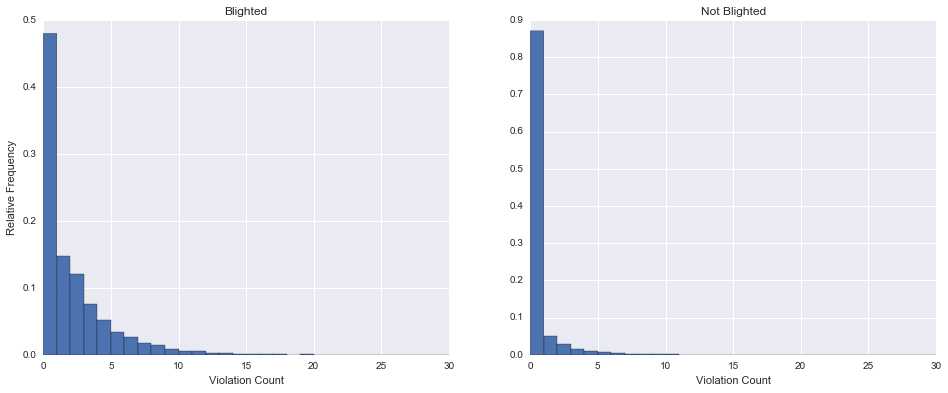

In [94]:
import numpy
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 30, 31)
plt.hist(blighted3['Violation_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 230, 231)
plt.hist(not_blighted3['Violation_Count'],bins, normed=1)
plt.title('Not Blighted')
plt.xlabel("Violation Count")
plt.axis([0, 30, 0.0, 0.9])
#fig.savefig('test.eps', format='eps')

[0, 40, 0.0, 0.7]

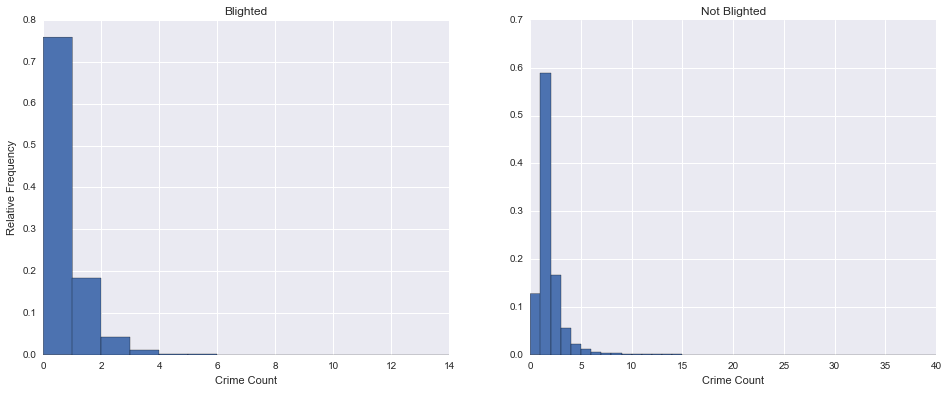

In [95]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 14, 15)
plt.hist(blighted3['Crime_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Crime Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 300, 301)
plt.hist(not_blighted3['Crime_Count'], bins, normed = 1)
plt.title('Not Blighted')
plt.xlabel("Crime Count")
plt.axis([0, 40, 0.0, 0.7])

[0, 10, 0.0, 1]

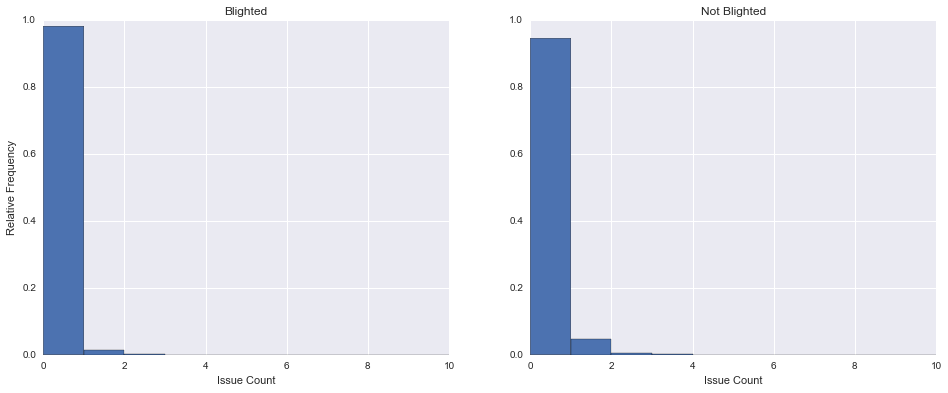

In [96]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 10, 11)
plt.hist(blighted3['Issue_Count'],bins, normed=1)
plt.title('Blighted')
plt.xlabel("Issue Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 400, 401)
plt.hist(not_blighted3['Issue_Count'], bins, normed = 1)
plt.title('Not Blighted')
plt.xlabel("Issue Count")
plt.axis([0, 10, 0.0, 1])

Now we will randomly select 10000 records out of **blighted3** and **not_blighted3** as our sample. Then we will devided the sample into training set and test set.

In [97]:
sample_blighted = blighted3.sample(n=10000)
sample_notblighted = not_blighted3.sample(n=10000)

sample_blighted = sample_blighted[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
sample_notblighted = sample_notblighted[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
sample = sample_blighted.append(sample_notblighted)

[0, 35, 0, 20]

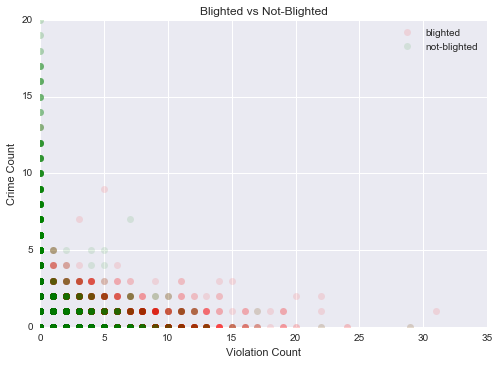

In [98]:
plt.plot(sample_blighted['Violation_Count'],sample_blighted['Crime_Count'],'ro',alpha = 0.1)
plt.plot(sample_notblighted['Violation_Count'],sample_notblighted['Crime_Count'],'go',alpha = 0.1)
plt.legend(['blighted','not-blighted'])
plt.title('Blighted vs Not-Blighted')
plt.xlabel("Violation Count")
plt.ylabel("Crime Count")
plt.axis([0, 35, 0, 20])

[0, 16, 0.0, 0.9]

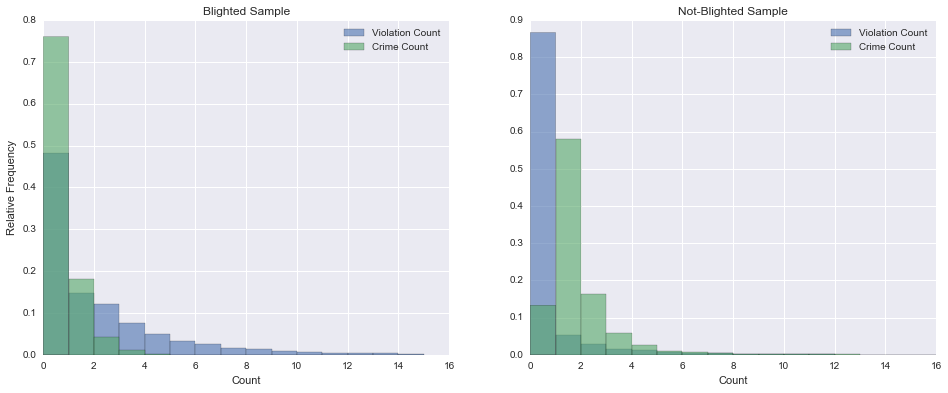

In [99]:
fig,ax=plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplot(121)
bins = numpy.linspace(0, 15, 16)
plt.hist(sample_blighted['Violation_Count'],bins, normed=1,alpha=0.6)
plt.hist(sample_blighted['Crime_Count'],bins, normed=1,alpha=0.6)
plt.title('Blighted Sample')
plt.legend(['Violation Count','Crime Count'])
plt.xlabel("Count")
plt.ylabel("Relative Frequency")

plt.subplot(122)
bins = numpy.linspace(0, 300, 301)
plt.hist(sample_notblighted['Violation_Count'],bins, normed=1,alpha=0.6)
plt.hist(sample_notblighted['Crime_Count'], bins, normed = 1,alpha=0.6)
plt.legend(['Violation Count','Crime Count'])
plt.title('Not-Blighted Sample')
plt.xlabel("Count")
plt.axis([0, 16, 0.0, 0.9])

## Model Selection and Training

We first build a model based on a single feature: Violation_Count, namely the number of records in *detroit-blight-violations.csv* associated with that building.

In [100]:
X = sample[['Violation_Count']]
y = sample['IsNewBlighted']

In [101]:
from sklearn import cross_validation
from sklearn import svm

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

In [102]:
modelsmv = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.69509528  0.689375    0.6915625   0.6959375   0.6895905 ]


In [103]:
modelsmv = svm.SVC(kernel='rbf', C=10)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.69509528  0.689375    0.6915625   0.6959375   0.6895905 ]


One feature doesnot seem to work well. We include the number of crimes associted with a building to the feature vector.

In [104]:
X = sample[['Violation_Count','Crime_Count']]
y = sample['IsNewBlighted']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

modelsmv = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.86629178  0.8546875   0.85        0.8596875   0.85276649]


Now the accuracy has been improved from around 70% to around 86%! We need to tune the superparameter see what is the best learning model for the data.

In [105]:
modelsmv = svm.SVC(kernel='rbf', C=10)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.86535458  0.8546875   0.85        0.8596875   0.85307909]


In [106]:
modelsmv = svm.SVC(kernel='rbf', C=0.1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.86566698  0.855625    0.84875     0.859375    0.8518287 ]


In [107]:
modelsmv = svm.SVC(kernel='linear', C=1)
scores = cross_validation.cross_val_score(modelsmv, X_train, y_train, cv=5)
print(scores)

[ 0.8291159  0.8265625  0.806875   0.82625    0.8246327]


Obviouly, the linear kernel in SVM is less suitale for our data set than the Gaussian kernel. The accuracy is about 83%. Within the model of SMV with Gaussian kernel, changing parameter C doesn't have large effect in the model performance.

We did not scale our feature vector. Now we preprocess the training feature set by standardization and still use 5-fold cross validation in the following.

In [108]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_validation.cross_val_score(clf, X_train, y_train, cv=5)

array([ 0.86566698,  0.854375  ,  0.8496875 ,  0.859375  ,  0.85276649])

The results are very close to the model without scaling. Now we add one more feature, the number of issues reported associates with a building.

In [109]:
X = sample[['Violation_Count','Crime_Count','Issue_Count']]
y = sample['IsNewBlighted']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

model_smv = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
score_smv = cross_validation.cross_val_score(model_smv, X_train, y_train, cv=5)
print(score_smv)
print(np.average(score_smv))

[ 0.88066229  0.869375    0.86625     0.8734375   0.86714598]
0.871374155231


We can see the accuracy improves slightly with this additional feature: Issue_Count.

In [110]:
from sklearn import tree

model_dt = tree.DecisionTreeClassifier()
score_dt = cross_validation.cross_val_score(model_dt, X_train, y_train, cv=5)
print(score_dt)
print("the average cross validation score by decition tree is",np.average(score_dt))

[ 0.87941268  0.8671875   0.865       0.874375    0.86714598]
the average cross validation score by decition tree is 0.870624233331


In [111]:
from sklearn.externals.six import StringIO

model_dt = model_dt.fit(X_train, y_train)

with open("dt.dot",'w') as f:
    f = tree.export_graphviz(model_dt, out_file = f)

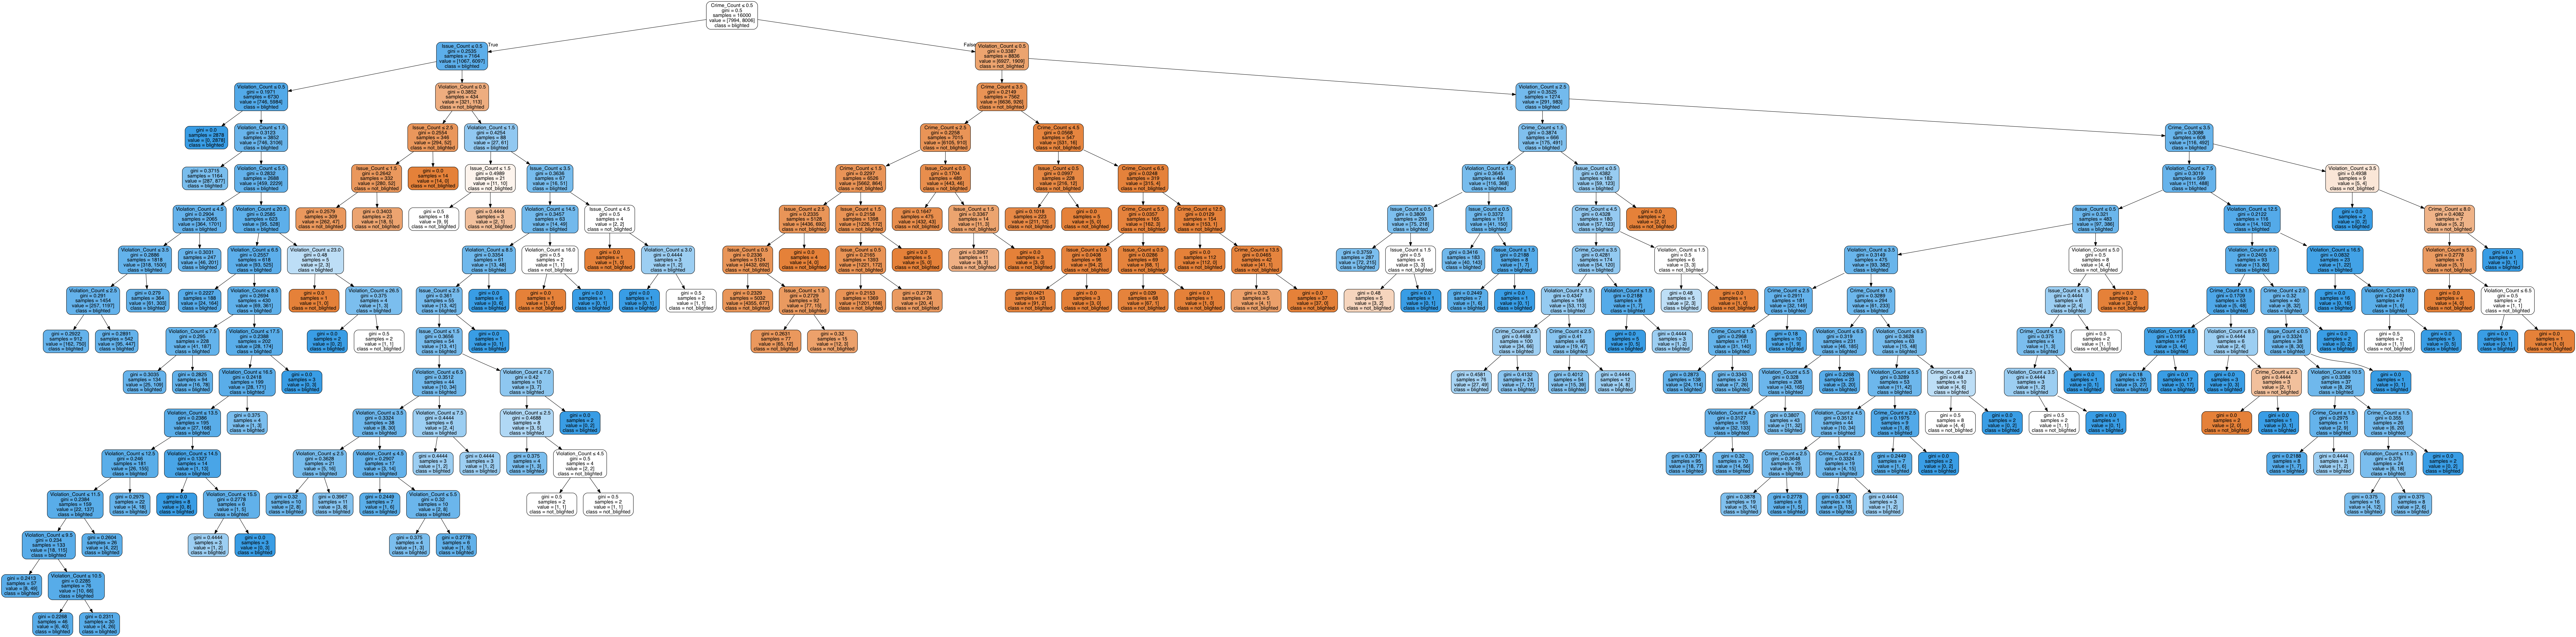

In [112]:
from IPython.display import Image  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(model_dt, out_file=dot_data,  
                         feature_names=X_train.columns,  
                         class_names=['not_blighted','blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dt.pdf") 
Image(graph.create_png())  

The decision tree model produces a similar accuracy score as the SVM. However, the above tree looks too complicated. We restrict the max depth of the tree and test what depth produces the most accurate model by cross validation.

In [113]:
for i in list(range(1,11,1)):
    model_dt = tree.DecisionTreeClassifier(max_depth = i)
    score_dt = cross_validation.cross_val_score(model_dt, X_train, y_train, cv=5)
    print("For max_depth=",i,", the CV scores are",score_dt, "and the mean is", score_dt.mean())

For max_depth= 1 , the CV scores are [ 0.81911903  0.8165625   0.8         0.8171875   0.81713035] and the mean is 0.813999875708
For max_depth= 2 , the CV scores are [ 0.87878788  0.8684375   0.865       0.8725      0.86652079] and the mean is 0.870249233307
For max_depth= 3 , the CV scores are [ 0.88034989  0.87        0.866875    0.8753125   0.86870897] and the mean is 0.872249272443
For max_depth= 4 , the CV scores are [ 0.88066229  0.8696875   0.866875    0.8746875   0.86839637] and the mean is 0.87206173338
For max_depth= 5 , the CV scores are [ 0.88003749  0.8696875   0.866875    0.8746875   0.86808378] and the mean is 0.871874252893
For max_depth= 6 , the CV scores are [ 0.88003749  0.8696875   0.8665625   0.8753125   0.86839637] and the mean is 0.87199927243
For max_depth= 7 , the CV scores are [ 0.88003749  0.869375    0.86625     0.8746875   0.86839637] and the mean is 0.87174927243
For max_depth= 8 , the CV scores are [ 0.88003749  0.8684375   0.86625     0.8746875   0.8677

In [114]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=None, min_samples_split=1,random_state=0)
score_rf = cross_validation.cross_val_score(model_rf, X_train, y_train, cv=5)
print(score_rf)
print("the average cross validation score by random forests is",np.average(score_rf))

[ 0.88003749  0.8678125   0.865625    0.8746875   0.86683339]
the average cross validation score by random forests is 0.870999174744


In [115]:
model_rf = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=3, min_samples_split=1,random_state=0)
score_rf = cross_validation.cross_val_score(model_rf, X_train, y_train, cv=5)
print(score_rf)
print("the average cross validation score by random forests with max_depth=3 is",np.average(score_rf))

[ 0.88066229  0.87        0.866875    0.8753125   0.86870897]
the average cross validation score by random forests with max_depth=3 is 0.872311752917


In the above, we also test the accuracy of the Random Forests model which is 0.8723 when max_depth=3. This is almost identical to the accuracy of the Decision Tree model with max_depth=3 (0.8722). The accuracy of the depth-3 tree is also slightly higher than that of the SVM model (0.8714). Therefore we take Decision Tree as our final model for simplicity and effectiveness.

We can see that the best Decision Tree model has max_depth = 3 with the mean accuracy = 0.8722. We choose max_depth = 3 and show the graph of the decison tree. We will also test our model on the test data set which are held out at the beginning.

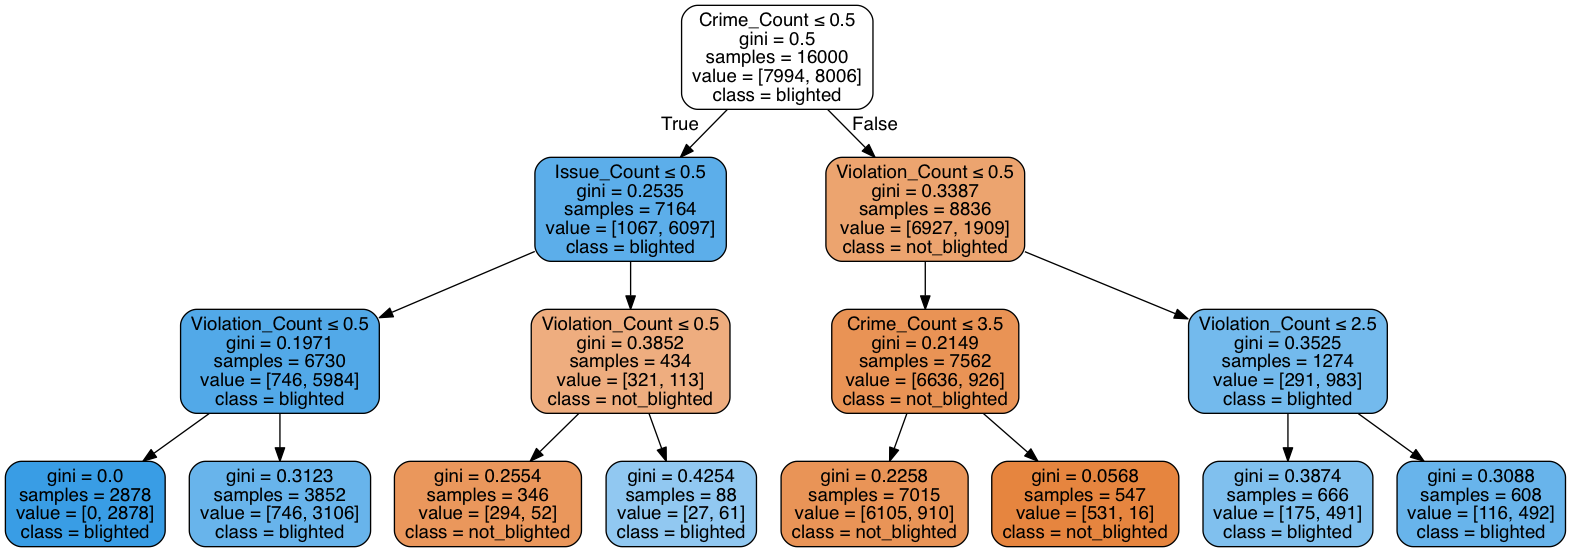

In [117]:
model_dt = tree.DecisionTreeClassifier(max_depth = 3)

model_dt = model_dt.fit(X_train, y_train)
dot_data = StringIO()  
tree.export_graphviz(model_dt, out_file=dot_data,  
                         feature_names=X_train.columns,  
                         class_names=['not_blighted','blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dt_3.pdf") 
Image(graph.create_png())  

The advantage of this decision tree model is that we can interpret the results directly from the graph. The orange leaves represent the not-blighted buildings and the blue represent the blighted ones. The branch right to the root with Crime_Count > 0.5 and Violation_Count <= 0.5 (or equivalently Violation_Count = 0) are all classified as not-blighted. The next right branch with Crime_Count > 0.5 and Violation_Count > 0.5 are mostly classified as blighted. This indicates in the area where crimes happen (Crime_Count > 0), the number of blight violations is the critical factor in determining whether a building is blighted or not. Except for some outliers, the non-blighted buildings don't have any blight violation records. 

On the other side (left side), where Crime_Count <= 0.5 (this simply means Crime_Count = 0), we can see if Issue_Count = 0, then almost all the samples are blighted buildings. This tells us that in the areas where no crimes occur and no issues are reported, the buildings are probably just blighted, and zero crimes or issues might just indicate a low population. At the branch of Crime_Count = 0 and Issue_Count > 0.5, if Violation_Count = 0, then the buildings are not-blighted, otherwise they are mostly blighted. This may tell us that people tend to report issues but not violate the blight regulation if they still live there, but after they abandon the house, the number of blight violations increase.

The root node is whether the Crime_Count is zero or not, and there are many blighted and non-blighted records on either side of the root. This indicates that the number of criminal incidents is not critical in determining whether a building is blighted or not. 

In [118]:
model_dt.score(X_test, y_test)

0.87224999999999997

In [119]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = model_dt.predict(X_test)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

not-blighted       0.88      0.86      0.87      2006
    blighted       0.87      0.88      0.87      1994

 avg / total       0.87      0.87      0.87      4000



Our model has 87.22% accuracy testing againest the test data set, and the precision and recall for each category is roughly the same as the accuracy. The metrics show that our model is reasonably good considering that the data are from the real world (the Detroite goverment data portal). Note that we have banlanced the category by selecting the same number of blighted and not-blighted from the total data set to form our training set. Next, we want to test our model for the total data set, which is extremely skewed with the number of the not-blighted buildings much larger than the blighted ones.

In [120]:
total_blighted = blighted3[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
total_notblighted = not_blighted3[['Violation_Count','Crime_Count','Issue_Count','IsNewBlighted']]
total_sample = total_blighted.append(total_notblighted)

Xt = total_sample[['Violation_Count','Crime_Count','Issue_Count']]
yt = total_sample['IsNewBlighted']

model_dt.score(Xt, yt)

0.87082883560921431

In [121]:
y_true = yt
y_pred = model_dt.predict(Xt)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

not-blighted       1.00      0.87      0.93    757346
    blighted       0.09      0.88      0.16     10635

 avg / total       0.99      0.87      0.92    767981



We want to find out the blighted buildings through the our model. The recall of the blighted class is 0.88 which is reasonably good. This means 88% of the blighted buldings are identified thourgh our model. The precison of the blighted class is very low though. This tells us that a large portion of the buildings identified as blighted are not really blighted. Since we label a building as blighted simply from the fact that it is demolished or to be demolished in the future, we cannot rule out the possibility that the building is actually blighted but not noticed by the government yet. The buildings identified as blighted through our model are worth future investigation. They may be already blighted but not reported, or will probably become blighted in the future.

On the other hand, the precision and recall of not-blighted class are reasonably good.

Next, we also train a Decision Tree model with the entire data set in the following. We want to check how the performance is different for a model trained with the skewed real data set.

In [123]:
Xt_train, Xt_test, yt_train, yt_test = cross_validation.train_test_split(Xt, yt, test_size=0.2, random_state=0)

model_dt2 = tree.DecisionTreeClassifier(max_depth = 4)
score_dt2 = cross_validation.cross_val_score(model_dt2, Xt_train, yt_train, cv=5)
print("The scores are", score_dt2, "and the mean is",score_dt2.mean())

The scores are [ 0.99100727  0.9908445   0.99115376  0.99124328  0.99101533] and the mean is 0.991052826836


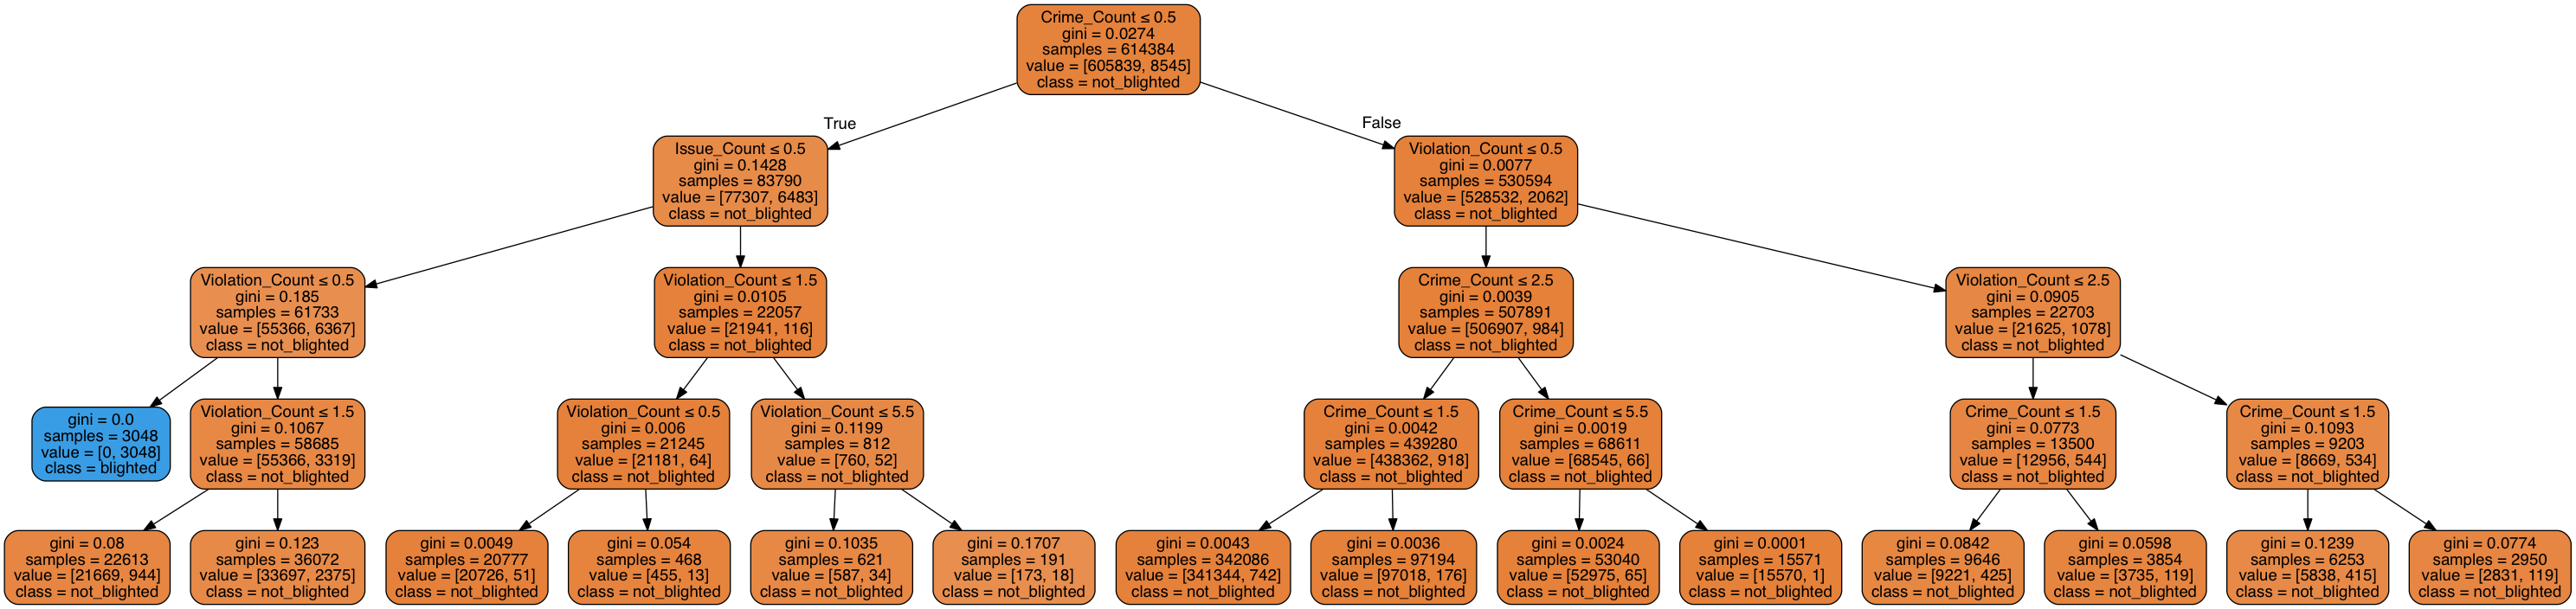

In [124]:
model_dt2 = model_dt2.fit(Xt_train, yt_train)

dot_data = StringIO()  
tree.export_graphviz(model_dt2, out_file=dot_data,  
                         feature_names=Xt_train.columns,  
                         class_names=['not_blighted','blighted'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dtl_4_totalsample.pdf") 
Image(graph.create_png()) 

In [125]:
y_true = yt_test
y_pred = model_dt2.predict(Xt_test)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

not-blighted       0.99      1.00      1.00    151507
    blighted       1.00      0.37      0.54      2090

 avg / total       0.99      0.99      0.99    153597



In [126]:
model_dt2 = tree.DecisionTreeClassifier(max_depth = None)
score_dt2 = cross_validation.cross_val_score(model_dt2, Xt_train, yt_train, cv=5)
print("The CV scores are", score_dt2, "and the mean is",score_dt2.mean())

model_dt2 = model_dt2.fit(Xt_train, yt_train)
y_true = yt_test
y_pred = model_dt2.predict(Xt_test)
target_names = ['not-blighted', 'blighted']
print(classification_report(y_true, y_pred, target_names=target_names))

The CV scores are [ 0.99099913  0.99085264  0.99116189  0.99123514  0.99101533] and the mean is 0.991052826836
              precision    recall  f1-score   support

not-blighted       0.99      1.00      1.00    151507
    blighted       1.00      0.37      0.54      2090

 avg / total       0.99      0.99      0.99    153597



The Decision Tree models (trained with the total data set) with max_depth=4 and max_depth=None behave identically as the metrics show. The precision of the blighted class is 1.0, indicating that all the identifed-as-blighted buildings are truly blighted. However, the recall of the blighted class is low (0.37), indicating that a large protion (63%) of the blighted buildings are not identified. This is not what we want. The goverment want to find out the potential blighted buildings so that actions can be taken to prevent it. We can tolerate a low precision, but we don't want to leave out many truly blighted buildings unidentifed in our model.

## Conclusion

We have successfully trained a Decision Tree model to predict the potential blight in the city of Detroit. The recall of the blighted class in our model is pretty high, which shows that our model is capable to identify the blighted buildings from a much larger set of blighted and not-blighted buildings. Our model has a low precision for the blighted class, this shows that some of the not-blighted buildings have very similar characters as the blighted ones. Although these not-blighted buildings are misclassified according to the demolition and future-demolition list, they may be actually blighted or near blighted and worth further investigation.